# 🧙 Potion Flow Monitoring Dashboard - Data Processing

## Hackathon Challenge: Poyo's Potion Factory Monitor

This notebook processes data from the Potion Factory API to:
- Load and analyze cauldron level time series data
- Calculate fill rates for each cauldron
- Detect drain events (potion collections)
- Match transport tickets to drain events
- Identify discrepancies and suspicious activity

## 1. Setup and Imports

In [47]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks

# Set visualization style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15, 6)

print("✓ All imports successful!")


✓ All imports successful!


## 2. Data Processor Class

In [71]:
class CauldronDataProcessor:
    """Main class for processing cauldron monitoring data."""
    
    BASE_URL = "https://hackutd2025.eog.systems"
    MARKET_UNLOAD_TIME_MINUTES = 15  # Time witches take to unload at market
    
    def __init__(self, cache_enabled: bool = True):
        """
        Initialize the data processor.
        
        Args:
            cache_enabled: Whether to cache API responses locally
        """
        self.cache_enabled = cache_enabled
        self.data_cache = {}
        self.fill_rates_cache = {}  # Cache calculated fill rates
        
    def fetch_api_data(self, endpoint: str, use_cache: bool = True) -> Dict:
        """
        Fetch data from API endpoint with optional caching.
        
        Args:
            endpoint: API endpoint path
            use_cache: Whether to use cached data if available
            
        Returns:
            JSON response as dictionary
        """
        cache_key = endpoint
        
        if use_cache and cache_key in self.data_cache:
            print(f"✓ Using cached data for {endpoint}")
            return self.data_cache[cache_key]
        
        url = f"{self.BASE_URL}{endpoint}"
        print(f"⬇ Fetching data from {endpoint}...")
        
        try:
            response = requests.get(url, timeout=30)
            response.raise_for_status()
            data = response.json()
            
            if self.cache_enabled:
                self.data_cache[cache_key] = data
                
            print(f"✓ Successfully fetched {endpoint}")
            return data
            
        except requests.exceptions.RequestException as e:
            print(f"✗ Error fetching {endpoint}: {e}")
            return {}
    
    def fetch_travel_times(self, cauldron_ids: List[str]) -> Dict[str, float]:
        """
        Fetch travel times from each cauldron to the market.
        
        Args:
            cauldron_ids: List of cauldron IDs to fetch travel times for
            
        Returns:
            Dictionary mapping cauldron_id to travel time in minutes
        """
        print("\n🔄 Fetching travel times to market...\n")
        travel_times = {}
        
        for cauldron_id in cauldron_ids:
            neighbors = self.fetch_api_data(f'/api/Information/graph/neighbors/{cauldron_id}')
            
            if isinstance(neighbors, list):
                for neighbor in neighbors:
                    if neighbor.get('to', '').startswith('market'):
                        # Parse time string format "HH:MM:SS" to minutes
                        cost_str = neighbor.get('cost', '00:00:00')
                        time_parts = cost_str.split(':')
                        if len(time_parts) == 3:
                            hours = int(time_parts[0])
                            minutes = int(time_parts[1])
                            seconds = int(time_parts[2])
                            total_minutes = hours * 60 + minutes + seconds / 60
                            travel_times[cauldron_id] = total_minutes
                            print(f"  {cauldron_id} → market: {total_minutes:.1f} minutes")
                            break
        
        print(f"\n✓ Fetched travel times for {len(travel_times)} cauldrons\n")
        return travel_times
    
    def fetch_all_data(self) -> Dict[str, any]:
        """
        Fetch all required data from API endpoints.
        
        Returns:
            Dictionary containing all datasets
        """
        print("\n🔄 Fetching all data from API...\n")
        
        datasets = {
            'level_data': self.fetch_api_data('/api/Data/?start_date=0&end_date=2000000000'),
            'tickets': self.fetch_api_data('/api/Tickets'),
            'cauldrons': self.fetch_api_data('/api/Information/cauldrons'),
            'network': self.fetch_api_data('/api/Information/network'),
            'couriers': self.fetch_api_data('/api/Information/couriers'),
            'market': self.fetch_api_data('/api/Information/market')
        }
        
        print("\n✓ All data fetched successfully!\n")
        return datasets
    
    def _normalize_json_data(self, data: Dict, key: Optional[str] = None) -> List:
        """Helper to normalize JSON data structure."""
        if isinstance(data, list):
            return data
        elif key and key in data:
            return data[key]
        else:
            return [data]
    
    def transform_level_data(self, level_data: Dict) -> pd.DataFrame:
        """Transform raw level data into time-indexed DataFrame."""
        print("🔄 Transforming potion level data...")
        records = self._normalize_json_data(level_data, 'data')
        df = pd.json_normalize(records)
        
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df = df.set_index('timestamp').sort_index()
        
        print(f"✓ Transformed {len(df)} records ({df.index.min()} to {df.index.max()})")
        return df
    
    def transform_tickets(self, tickets_data: Dict) -> pd.DataFrame:
        """Transform tickets data into DataFrame."""
        print("🔄 Transforming ticket data...")
        tickets = self._normalize_json_data(tickets_data, 'transport_tickets')
        df = pd.DataFrame(tickets)
        
        if 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date'])
        
        print(f"✓ Transformed {len(df)} tickets | Total volume: {df['amount_collected'].sum():.2f}L")
        return df
    
    def transform_cauldrons(self, cauldrons_data: Dict) -> pd.DataFrame:
        """Transform cauldrons metadata into DataFrame."""
        print("🔄 Transforming cauldron metadata...")
        cauldrons = self._normalize_json_data(cauldrons_data)
        df = pd.DataFrame(cauldrons)
        
        if 'id' in df.columns:
            df = df.set_index('id')
        
        print(f"✓ Transformed {len(df)} cauldrons")
        return df

print("✓ CauldronDataProcessor class defined!")


✓ CauldronDataProcessor class defined!


## 3. Fetch Data from API


In [72]:
# Initialize processor
processor = CauldronDataProcessor(cache_enabled=True)

# Fetch all data
raw_data = processor.fetch_all_data()

# Transform into DataFrames
df_levels = processor.transform_level_data(raw_data['level_data'])
df_tickets = processor.transform_tickets(raw_data['tickets'])
df_cauldrons = processor.transform_cauldrons(raw_data['cauldrons'])

# Fetch travel times from cauldrons to market
# Extract cauldron IDs from the columns
cauldron_ids = [col.replace('cauldron_levels.', '') for col in df_levels.columns if 'cauldron' in col.lower()]
travel_times = processor.fetch_travel_times(cauldron_ids)

print("\n" + "="*60)
print("DATA SUMMARY")
print("="*60)
print(f"Level measurements: {len(df_levels)} records")
print(f"Transport tickets: {len(df_tickets)} tickets")
print(f"Cauldrons tracked: {len(df_cauldrons)} cauldrons")
print(f"Travel times fetched: {len(travel_times)} cauldrons")
print("="*60)



🔄 Fetching all data from API...

⬇ Fetching data from /api/Data/?start_date=0&end_date=2000000000...
✓ Successfully fetched /api/Data/?start_date=0&end_date=2000000000
⬇ Fetching data from /api/Tickets...
✓ Successfully fetched /api/Tickets
⬇ Fetching data from /api/Information/cauldrons...
✓ Successfully fetched /api/Information/cauldrons
⬇ Fetching data from /api/Information/network...
✓ Successfully fetched /api/Information/network
⬇ Fetching data from /api/Information/couriers...
✓ Successfully fetched /api/Information/couriers
⬇ Fetching data from /api/Information/market...
✓ Successfully fetched /api/Information/market

✓ All data fetched successfully!

🔄 Transforming potion level data...
✓ Transformed 15840 records (2025-10-30 00:00:00+00:00 to 2025-11-09 23:59:00+00:00)
🔄 Transforming ticket data...
✓ Transformed 149 tickets | Total volume: 13012.94L
🔄 Transforming cauldron metadata...
✓ Transformed 12 cauldrons

🔄 Fetching travel times to market...

⬇ Fetching data from /api/

## 4. Calculate Fill Rates

Calculate the fill rate for each cauldron by analyzing periods where levels steadily increase.


In [73]:
# Quick data verification
print(f"✓ Data loaded: {df_levels.shape[0]} records × {df_levels.shape[1]} cauldrons")


✓ Data loaded: 15840 records × 12 cauldrons


Analyzing cauldron_levels.cauldron_001...
Data points: 15840
Value range: 226.98 to 724.11

Rate of change statistics:
  Mean rate: 0.0261 L/min
  Median rate: 0.0500 L/min
  Std dev: 0.2165 L/min
  Min rate: -0.4500 L/min
  Max rate: 0.4400 L/min


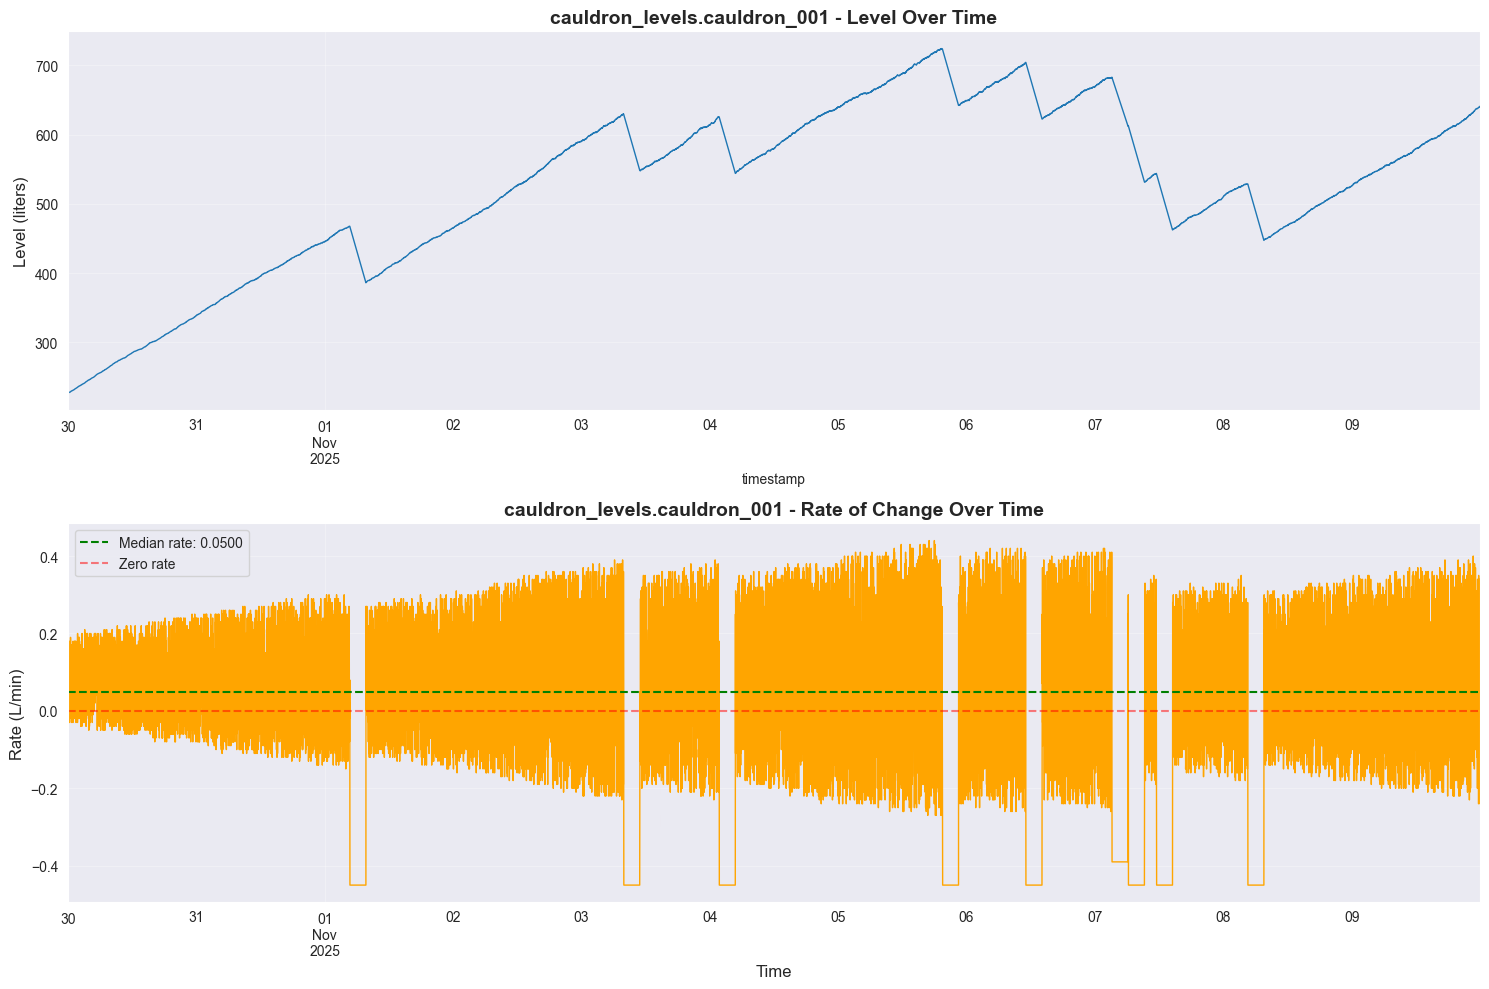


Looking for rate anomalies...
Threshold for anomaly detection: -0.3830 L/min
Found 1629 time points with anomalous rates
No cauldron columns found!


In [75]:
# Let's examine one cauldron in detail to understand the patterns
cauldron_cols = [col for col in df_levels.columns if 'cauldron' in col.lower()]

for i in range(1): #len(cauldron_cols)
    # Pick first cauldron for detailed analysis
    sample_col = cauldron_cols[i]
    sample_data = df_levels[sample_col].dropna()
    
    print(f"Analyzing {sample_col}...")
    print(f"Data points: {len(sample_data)}")
    print(f"Value range: {sample_data.min():.2f} to {sample_data.max():.2f}")
    
    # Calculate rate of change (derivative)
    time_diffs = sample_data.index.to_series().diff().dt.total_seconds() / 60  # minutes
    level_diffs = sample_data.diff()
    rates = level_diffs / time_diffs  # liters per minute
    
    print(f"\nRate of change statistics:")
    print(f"  Mean rate: {rates.mean():.4f} L/min")
    print(f"  Median rate: {rates.median():.4f} L/min")
    print(f"  Std dev: {rates.std():.4f} L/min")
    print(f"  Min rate: {rates.min():.4f} L/min")
    print(f"  Max rate: {rates.max():.4f} L/min")
    
    # Plot the data and its rate of change
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot levels
    sample_data.plot(ax=ax1, linewidth=1)
    ax1.set_title(f'{sample_col} - Level Over Time', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Level (liters)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Plot rate of change
    rates.plot(ax=ax2, linewidth=1, color='orange')
    ax2.axhline(y=rates.median(), color='green', linestyle='--', label=f'Median rate: {rates.median():.4f}')
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Zero rate')
    ax2.set_title(f'{sample_col} - Rate of Change Over Time', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Rate (L/min)', fontsize=12)
    ax2.set_xlabel('Time', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Look for periods where rate drops significantly
    print("\nLooking for rate anomalies...")
    median_rate = rates.median()
    std_rate = rates.std()
    
    # Define threshold as significant deviation from median
    threshold = median_rate - 2 * std_rate
    print(f"Threshold for anomaly detection: {threshold:.4f} L/min")
    
    anomalies = rates[rates < threshold]
    print(f"Found {len(anomalies)} time points with anomalous rates")
else:
    print("No cauldron columns found!")


## 6. Detect Drain Events (Sharp Drop Detection)

Drain events are when potion is collected from cauldrons. From the visualization in Section 4.5, we can see clear drain events characterized by:
- **Sharp drops in cauldron levels** (sawtooth pattern)
- **Sharp negative spikes in rate of change** (rate goes significantly negative)

The algorithm detects these by identifying periods where the rate becomes significantly negative.


In [76]:
def _calculate_drain_volume(level_before: float, level_after: float, 
                           fill_rate: float, drain_duration: float) -> float:
    """Calculate total potion collected during a drain event."""
    level_drop = level_before - level_after
    potion_generated = fill_rate * drain_duration
    return level_drop + potion_generated

def _calculate_ticket_date(drain_end: datetime, travel_time_minutes: float) -> datetime.date:
    """Calculate the date when ticket would be reported (after travel to market)."""
    arrival_at_market = drain_end + timedelta(minutes=travel_time_minutes)
    return arrival_at_market.date()

def detect_drain_events(series: pd.Series, cauldron_id: str, 
                                       normal_fill_rate: float,
                                       travel_time_minutes: float = 0,
                                       negative_rate_threshold: float = -0.05,
                                       min_drop_volume: float = 20.0) -> pd.DataFrame:
    """
    Detect drain events by identifying sharp negative rate spikes.
    
    Based on the visualization, drain events show as:
    - Sharp drops in level (sawtooth pattern)
    - Sharp negative spikes in rate of change
    - Brief duration events
    
    Args:
        series: Time series of cauldron levels
        cauldron_id: ID of the cauldron
        normal_fill_rate: Normal fill rate in units per minute
        travel_time_minutes: Travel time from cauldron to market (for ticket date assignment)
        negative_rate_threshold: Rate threshold to identify drains (e.g., -0.05 means rate < -0.05)
        min_drop_volume: Minimum volume drop to consider as drain event (liters)
        
    Returns:
        DataFrame with detected drain events
    """
    series = series.dropna()
    if len(series) < 3:
        return pd.DataFrame()
    
    # Calculate instantaneous rates
    time_diffs = series.index.to_series().diff().dt.total_seconds() / 60  # minutes
    level_diffs = series.diff()
    rates = level_diffs / time_diffs  # liters per minute
    
    # Find points where rate goes significantly negative (sharp drops)
    is_draining = rates < negative_rate_threshold
    
    # Find drain events by looking for consecutive negative rate periods
    drain_events = []
    in_drain = False
    drain_start = None
    drain_start_idx = None
    peak_level = None
    peak_idx = None
    
    for i in range(len(series)):
        timestamp = series.index[i]
        level = series.iloc[i]
        is_drain_point = is_draining.iloc[i] if i < len(is_draining) else False
        
        if not in_drain:
            # Track the peak level before drain
            if peak_level is None or level > peak_level:
                peak_level = level
                peak_idx = i
                peak_time = timestamp
            
            # Start of drain detected
            if is_drain_point:
                in_drain = True
                drain_start = timestamp
                drain_start_idx = i
                
        else:
            # We're in a drain period
            if not is_drain_point:
                # End of drain - rate returned to positive/normal
                drain_end = timestamp
                drain_end_idx = i
                level_after = level
                
                # Use the peak level before drain started
                level_before = peak_level
                level_drop = level_before - level_after
                
                # Calculate drain duration
                drain_duration = (drain_end - drain_start).total_seconds() / 60
                
                # Calculate volume collected
                # During drain, potion continues filling at normal rate
                potion_generated_during_drain = normal_fill_rate * drain_duration
                total_collected = level_drop + potion_generated_during_drain
                
                # Only record if significant drop occurred
                if level_drop >= min_drop_volume and total_collected > 0:
                    ticket_date = _calculate_ticket_date(drain_end, travel_time_minutes)
                    
                    drain_events.append({
                        'cauldron_id': cauldron_id,
                        'start_time': drain_start,
                        'end_time': drain_end,
                        'date': drain_end.date(),
                        'ticket_date': ticket_date,
                        'level_before': level_before,
                        'level_after': level_after,
                        'level_drop': level_drop,
                        'drain_duration_min': drain_duration,
                        'potion_generated_during_drain': potion_generated_during_drain,
                        'total_collected': total_collected,
                        'min_rate_during_drain': rates.iloc[drain_start_idx:drain_end_idx].min()
                    })
                
                # Reset for next drain
                in_drain = False
                drain_start = None
                drain_start_idx = None
                peak_level = level
                peak_idx = i
    
    return pd.DataFrame(drain_events)


# Detect drain events for all cauldrons using sharp drop detection
print("\n🔄 Detecting drain events by identifying sharp negative rate spikes...\n")
print("(Looking for clear drain events with negative rates and level drops)\n")

all_drain_events = []

for col in cauldron_cols:
    cauldron_id = col.replace('cauldron_levels.', '')
    fill_rate = fill_rates.get(col, np.nan)
    travel_time = travel_times.get(cauldron_id, 0)
    
    if np.isnan(fill_rate) or fill_rate <= 0:
        print(f"{cauldron_id}: Skipping (invalid fill rate)")
        continue
    
    # Detect sharp drain events with travel time adjustment
    events = detect_drain_events(
        df_levels[col], 
        cauldron_id, 
        fill_rate,
        travel_time_minutes=travel_time,  # Adjust ticket date for travel time
        negative_rate_threshold=-0.05,    # Rate must go below -0.05 L/min
        min_drop_volume=20.0               # Level must drop at least 20 liters
    )
    
    all_drain_events.append(events)
    print(f"{cauldron_id}: {len(events)} drain events detected")

# Combine all drain events
if len(all_drain_events) > 0 and any(len(df) > 0 for df in all_drain_events):
    df_drain_events = pd.concat([df for df in all_drain_events if len(df) > 0], ignore_index=True)
    df_drain_events = df_drain_events.sort_values('end_time')
    
    print(f"\n✓ Total drain events detected: {len(df_drain_events)}")
    print(f"  Total potion collected: {df_drain_events['total_collected'].sum():.2f} liters")
else:
    df_drain_events = pd.DataFrame()
    print("\n⚠️ No drain events detected with current parameters")
    print("Try adjusting negative_rate_threshold (more negative = more sensitive)")
    print("or min_drop_volume (lower = catch smaller drains)")



🔄 Detecting drain events by identifying sharp negative rate spikes...

(Looking for clear drain events with negative rates and level drops)

cauldron_001: 9 drain events detected
cauldron_002: 12 drain events detected
cauldron_003: 9 drain events detected
cauldron_004: 8 drain events detected
cauldron_005: 12 drain events detected
cauldron_006: 8 drain events detected
cauldron_007: 10 drain events detected
cauldron_008: 21 drain events detected
cauldron_009: 14 drain events detected
cauldron_010: 13 drain events detected
cauldron_011: 16 drain events detected
cauldron_012: 9 drain events detected

✓ Total drain events detected: 141
  Total potion collected: 13674.37 liters


In [78]:
# Display sample drain events
print("\n📊 SAMPLE DRAIN EVENTS:")
if len(df_drain_events) > 0:
    print(df_drain_events.head(15).to_string(index=False))
else:
    print("No drain events detected. See section 6.5 to adjust detection parameters.")



📊 SAMPLE DRAIN EVENTS:
 cauldron_id                start_time                  end_time       date ticket_date  level_before  level_after  level_drop  drain_duration_min  potion_generated_during_drain  total_collected  min_rate_during_drain
cauldron_012 2025-10-30 00:15:00+00:00 2025-10-30 03:16:00+00:00 2025-10-30  2025-10-30        175.23        92.00       83.23               181.0                          18.10           101.33                  -0.46
cauldron_011 2025-10-30 05:44:00+00:00 2025-10-30 08:47:00+00:00 2025-10-30  2025-10-30        441.61       360.23       81.38               183.0                          20.13           101.51                  -0.45
cauldron_011 2025-10-30 10:16:00+00:00 2025-10-30 13:17:00+00:00 2025-10-30  2025-10-30        369.11       287.71       81.40               181.0                          19.91           101.31                  -0.45
cauldron_010 2025-10-30 11:20:00+00:00 2025-10-30 14:21:00+00:00 2025-10-30  2025-10-30        254.93   

## 7. Match Drain Events to Tickets

Now we match each detected drain event to the corresponding transport ticket. 

**Important:** Ticket dates account for travel time to market. If a drain ends close to midnight and the courier needs time to reach the market, the ticket will be dated for the day the courier arrives (potentially the next day).


In [79]:
def match_drains_to_tickets(df_drains: pd.DataFrame, df_tickets: pd.DataFrame, 
                            tolerance_pct: float = 10.0) -> pd.DataFrame:
    """
    Match each drain event to tickets reported on the same day.
    
    For each drain event, finds tickets on the same date and cauldron,
    then determines if the drain was properly reported, under-reported, or not reported.
    
    Args:
        df_drains: DataFrame with detected drain events
        df_tickets: DataFrame with ticket data
        tolerance_pct: Percentage tolerance for volume matching
        
    Returns:
        DataFrame with each drain and its ticket match status
    """
    results = []
    
    for _, drain in df_drains.iterrows():
        # Use ticket_date which accounts for travel time to market
        # If drain ends close to midnight, courier arrives next day
        ticket_date = drain.get('ticket_date', drain['date'])  # Fall back to drain date if no ticket_date
        cauldron_id = drain['cauldron_id']
        drain_amount = drain['total_collected']
        
        # Find all tickets for this cauldron on the ticket date (not drain date)
        matching_tickets = df_tickets[
            (df_tickets['cauldron_id'] == cauldron_id) & 
            (df_tickets['date'].dt.date == ticket_date)
        ]
        
        if len(matching_tickets) == 0:
            # No ticket found for this drain
            results.append({
                'drain_id': f"{cauldron_id}_{drain['end_time']}",
                'cauldron_id': cauldron_id,
                'drain_date': drain['date'],  # Actual drain date
                'ticket_date': ticket_date,    # Expected ticket date (after travel)
                'drain_time': drain['end_time'],
                'drain_amount': drain_amount,
                'ticket_id': None,
                'ticket_amount': None,
                'difference': None,
                'difference_pct': None,
                'status': 'NO_TICKET_FOUND',
                'notes': 'Drain event detected but no ticket reported on expected date'
            })
        else:
            # Find best matching ticket by volume
            best_ticket = None
            min_diff = float('inf')
            
            for _, ticket in matching_tickets.iterrows():
                diff = abs(drain_amount - ticket['amount_collected'])
                if diff < min_diff:
                    min_diff = diff
                    best_ticket = ticket
            
            ticket_amount = best_ticket['amount_collected']
            
            # Calculate percentage difference
            pct_diff = (min_diff / drain_amount) * 100 if drain_amount > 0 else 0
            
            # Determine status
            if abs(pct_diff) <= tolerance_pct:
                status = 'MATCHED'
                notes = f'Ticket matches drain (difference: {pct_diff:.2f}%)'
            elif ticket_amount < drain_amount:
                # Ticket reports less than what was drained
                under_reported_amount = drain_amount - ticket_amount
                status = 'UNDER_REPORTED'
                notes = f'Ticket under-reports by {under_reported_amount:.2f}L ({pct_diff:.2f}%)'
            else:
                # Ticket reports more than what was drained
                over_reported_amount = ticket_amount - drain_amount
                status = 'OVER_REPORTED'
                notes = f'Ticket over-reports by {over_reported_amount:.2f}L ({pct_diff:.2f}%)'
            
            results.append({
                'drain_id': f"{cauldron_id}_{drain['end_time']}",
                'cauldron_id': cauldron_id,
                'drain_date': drain['date'],  # Actual drain date
                'ticket_date': ticket_date,    # Expected ticket date (after travel)
                'drain_time': drain['end_time'],
                'drain_amount': drain_amount,
                'ticket_id': best_ticket['ticket_id'],
                'ticket_amount': ticket_amount,
                'difference': ticket_amount - drain_amount,  # Positive = over-reported, Negative = under-reported
                'difference_pct': pct_diff,
                'status': status,
                'notes': notes
            })
    
    return pd.DataFrame(results)


# Match drain events to tickets
print("\n🔄 Matching drain events to tickets...\n")
print("For each detected drain, finding tickets reported on the same day...\n")

if len(df_drain_events) > 0:
    df_matched = match_drains_to_tickets(df_drain_events, df_tickets, tolerance_pct=2.0)
    
    # Summary statistics
    print("="*60)
    print("DRAIN EVENT MATCHING SUMMARY")
    print("="*60)
    print(f"Total drain events: {len(df_matched)}")
    print(f"Matched drains: {len(df_matched[df_matched['status'] == 'MATCHED'])}")
    print(f"Under-reported drains: {len(df_matched[df_matched['status'] == 'UNDER_REPORTED'])}")
    print(f"Over-reported drains: {len(df_matched[df_matched['status'] == 'OVER_REPORTED'])}")
    print(f"No ticket found: {len(df_matched[df_matched['status'] == 'NO_TICKET_FOUND'])}")
    print("="*60)
    
    # Additional statistics
    if len(df_matched[df_matched['status'] == 'UNDER_REPORTED']) > 0:
        under_reported = df_matched[df_matched['status'] == 'UNDER_REPORTED']
        total_under_reported = under_reported['difference'].sum() * -1  # Make positive
        print(f"\n⚠️ Total under-reported volume: {total_under_reported:.2f} liters")
    
else:
    print("⚠️ Cannot match - no drain events detected yet.")
    df_matched = pd.DataFrame()



🔄 Matching drain events to tickets...

For each detected drain, finding tickets reported on the same day...

DRAIN EVENT MATCHING SUMMARY
Total drain events: 141
Matched drains: 18
Under-reported drains: 96
Over-reported drains: 2
No ticket found: 25

⚠️ Total under-reported volume: 975.20 liters


## 7.4. Color-Coded Drain Event Visualization

Visualize drains with color coding based on ticket matching status:
- 🟢 Green = Matched
- 🟡 Yellow = Under-reported  
- 🔴 Red = No ticket found


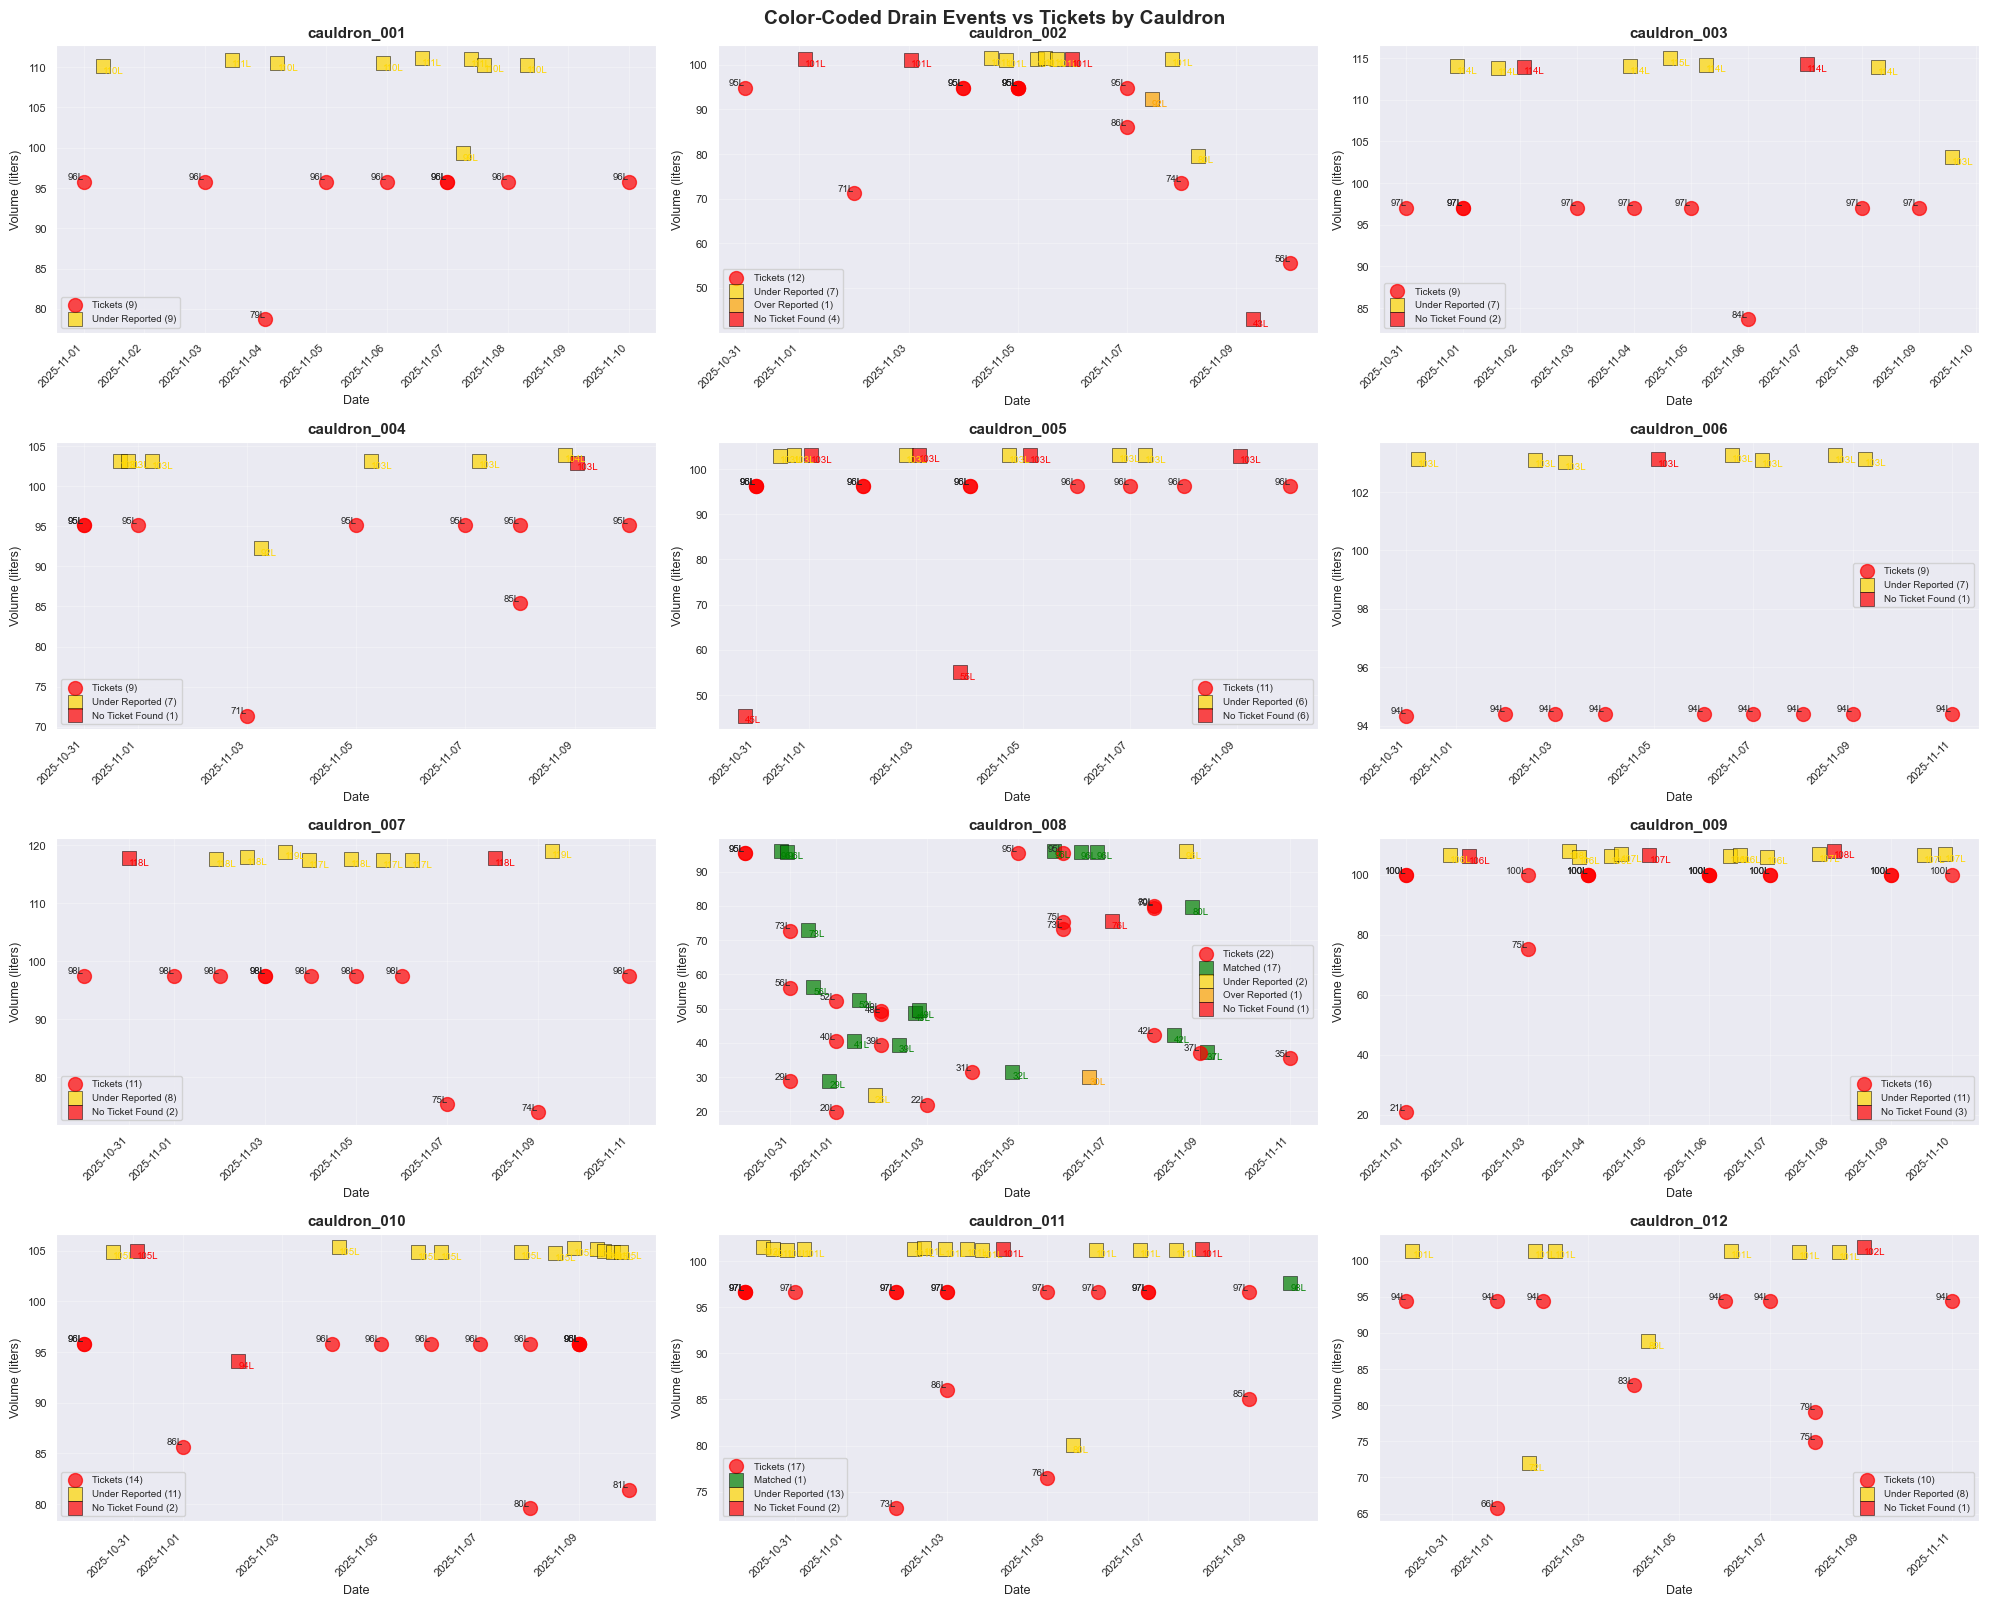

In [83]:
# Color-coded drain visualization based on ticket matching
if len(df_drain_events) > 0 and len(df_matched) > 0:
    # Create timeline comparison for each cauldron
    fig, axes = plt.subplots(4, 3, figsize=(20, 16))
    axes = axes.flatten()
    
    all_cauldron_ids = sorted(df_tickets['cauldron_id'].unique())
    
    # Define colors for each status
    status_colors = {
        'MATCHED': 'green',
        'UNDER_REPORTED': 'gold',
        'OVER_REPORTED': 'orange',
        'NO_TICKET_FOUND': 'red'
    }
    
    for idx, cauldron_id in enumerate(all_cauldron_ids):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        
        # Get tickets for this cauldron
        cauldron_tickets = df_tickets[df_tickets['cauldron_id'] == cauldron_id].sort_values('date')
        
        # Get matched drain info for this cauldron
        cauldron_matches = df_matched[df_matched['cauldron_id'] == cauldron_id].sort_values('drain_time')
        
        # Plot tickets as red circles
        if len(cauldron_tickets) > 0:
            ticket_dates = pd.to_datetime(cauldron_tickets['date'])
            ticket_amounts = cauldron_tickets['amount_collected']
            ax.scatter(ticket_dates, ticket_amounts, color='red', marker='o', 
                      s=100, alpha=0.7, label=f'Tickets ({len(cauldron_tickets)})', zorder=3)
            
            # Add ticket labels
            for _, ticket in cauldron_tickets.iterrows():
                ax.text(pd.to_datetime(ticket['date']), ticket['amount_collected'], 
                       f"{ticket['amount_collected']:.0f}L", 
                       fontsize=7, ha='right', va='bottom')
        
        # Plot drain events with color coding by status
        if len(cauldron_matches) > 0:
            for status, color in status_colors.items():
                status_drains = cauldron_matches[cauldron_matches['status'] == status]
                
                if len(status_drains) > 0:
                    drain_dates = pd.to_datetime(status_drains['drain_time'])
                    drain_amounts = status_drains['drain_amount']
                    
                    ax.scatter(drain_dates, drain_amounts, color=color, marker='s', 
                              s=100, alpha=0.7, label=f'{status.replace("_", " ").title()} ({len(status_drains)})', 
                              zorder=2, edgecolors='black', linewidths=0.5)
            
            # Add drain labels
            for _, match in cauldron_matches.iterrows():
                color = status_colors.get(match['status'], 'blue')
                ax.text(pd.to_datetime(match['drain_time']), match['drain_amount'], 
                       f"{match['drain_amount']:.0f}L", 
                       fontsize=7, ha='left', va='top', color=color)
        
        ax.set_title(f"{cauldron_id}", fontsize=11, fontweight='bold')
        ax.set_xlabel('Date', fontsize=9)
        ax.set_ylabel('Volume (liters)', fontsize=9)
        ax.legend(fontsize=7, loc='best')
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=8)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Hide unused subplots
    for idx in range(len(all_cauldron_ids), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('Color-Coded Drain Events vs Tickets by Cauldron', 
                 fontsize=14, fontweight='bold', y=1.001)
    plt.show()
    
else:
    print("\n⚠️ No drain events or matching data to visualize")


In [84]:
# Show matched drains sample
print("\n✓ SUCCESSFULLY MATCHED DRAINS (Sample):")
if len(df_matched) > 0:
    matched = df_matched[df_matched['status'] == 'MATCHED']
    if len(matched) > 0:
        print(f"Showing first 10 of {len(matched)} matched drains:\n")
        print(matched[['cauldron_id', 'drain_date', 'drain_amount', 'ticket_amount', 
                      'difference_pct']].head(10).to_string(index=False))
    else:
        print("No matched drains found!")
else:
    print("No drain events to analyze.")



✓ SUCCESSFULLY MATCHED DRAINS (Sample):
Showing first 10 of 18 matched drains:

 cauldron_id drain_date  drain_amount  ticket_amount  difference_pct
cauldron_008 2025-10-30         95.92          95.35        0.594245
cauldron_008 2025-10-30         95.82          95.35        0.490503
cauldron_008 2025-10-31         72.98          72.76        0.301452
cauldron_008 2025-10-31         56.21          56.07        0.249066
cauldron_008 2025-10-31         28.90          28.79        0.380623
cauldron_008 2025-11-01         40.62          40.41        0.516987
cauldron_008 2025-11-01         52.41          52.10        0.591490
cauldron_008 2025-11-02         39.43          39.20        0.583312
cauldron_008 2025-11-02         48.62          48.38        0.493624
cauldron_008 2025-11-02         49.49          49.25        0.484946


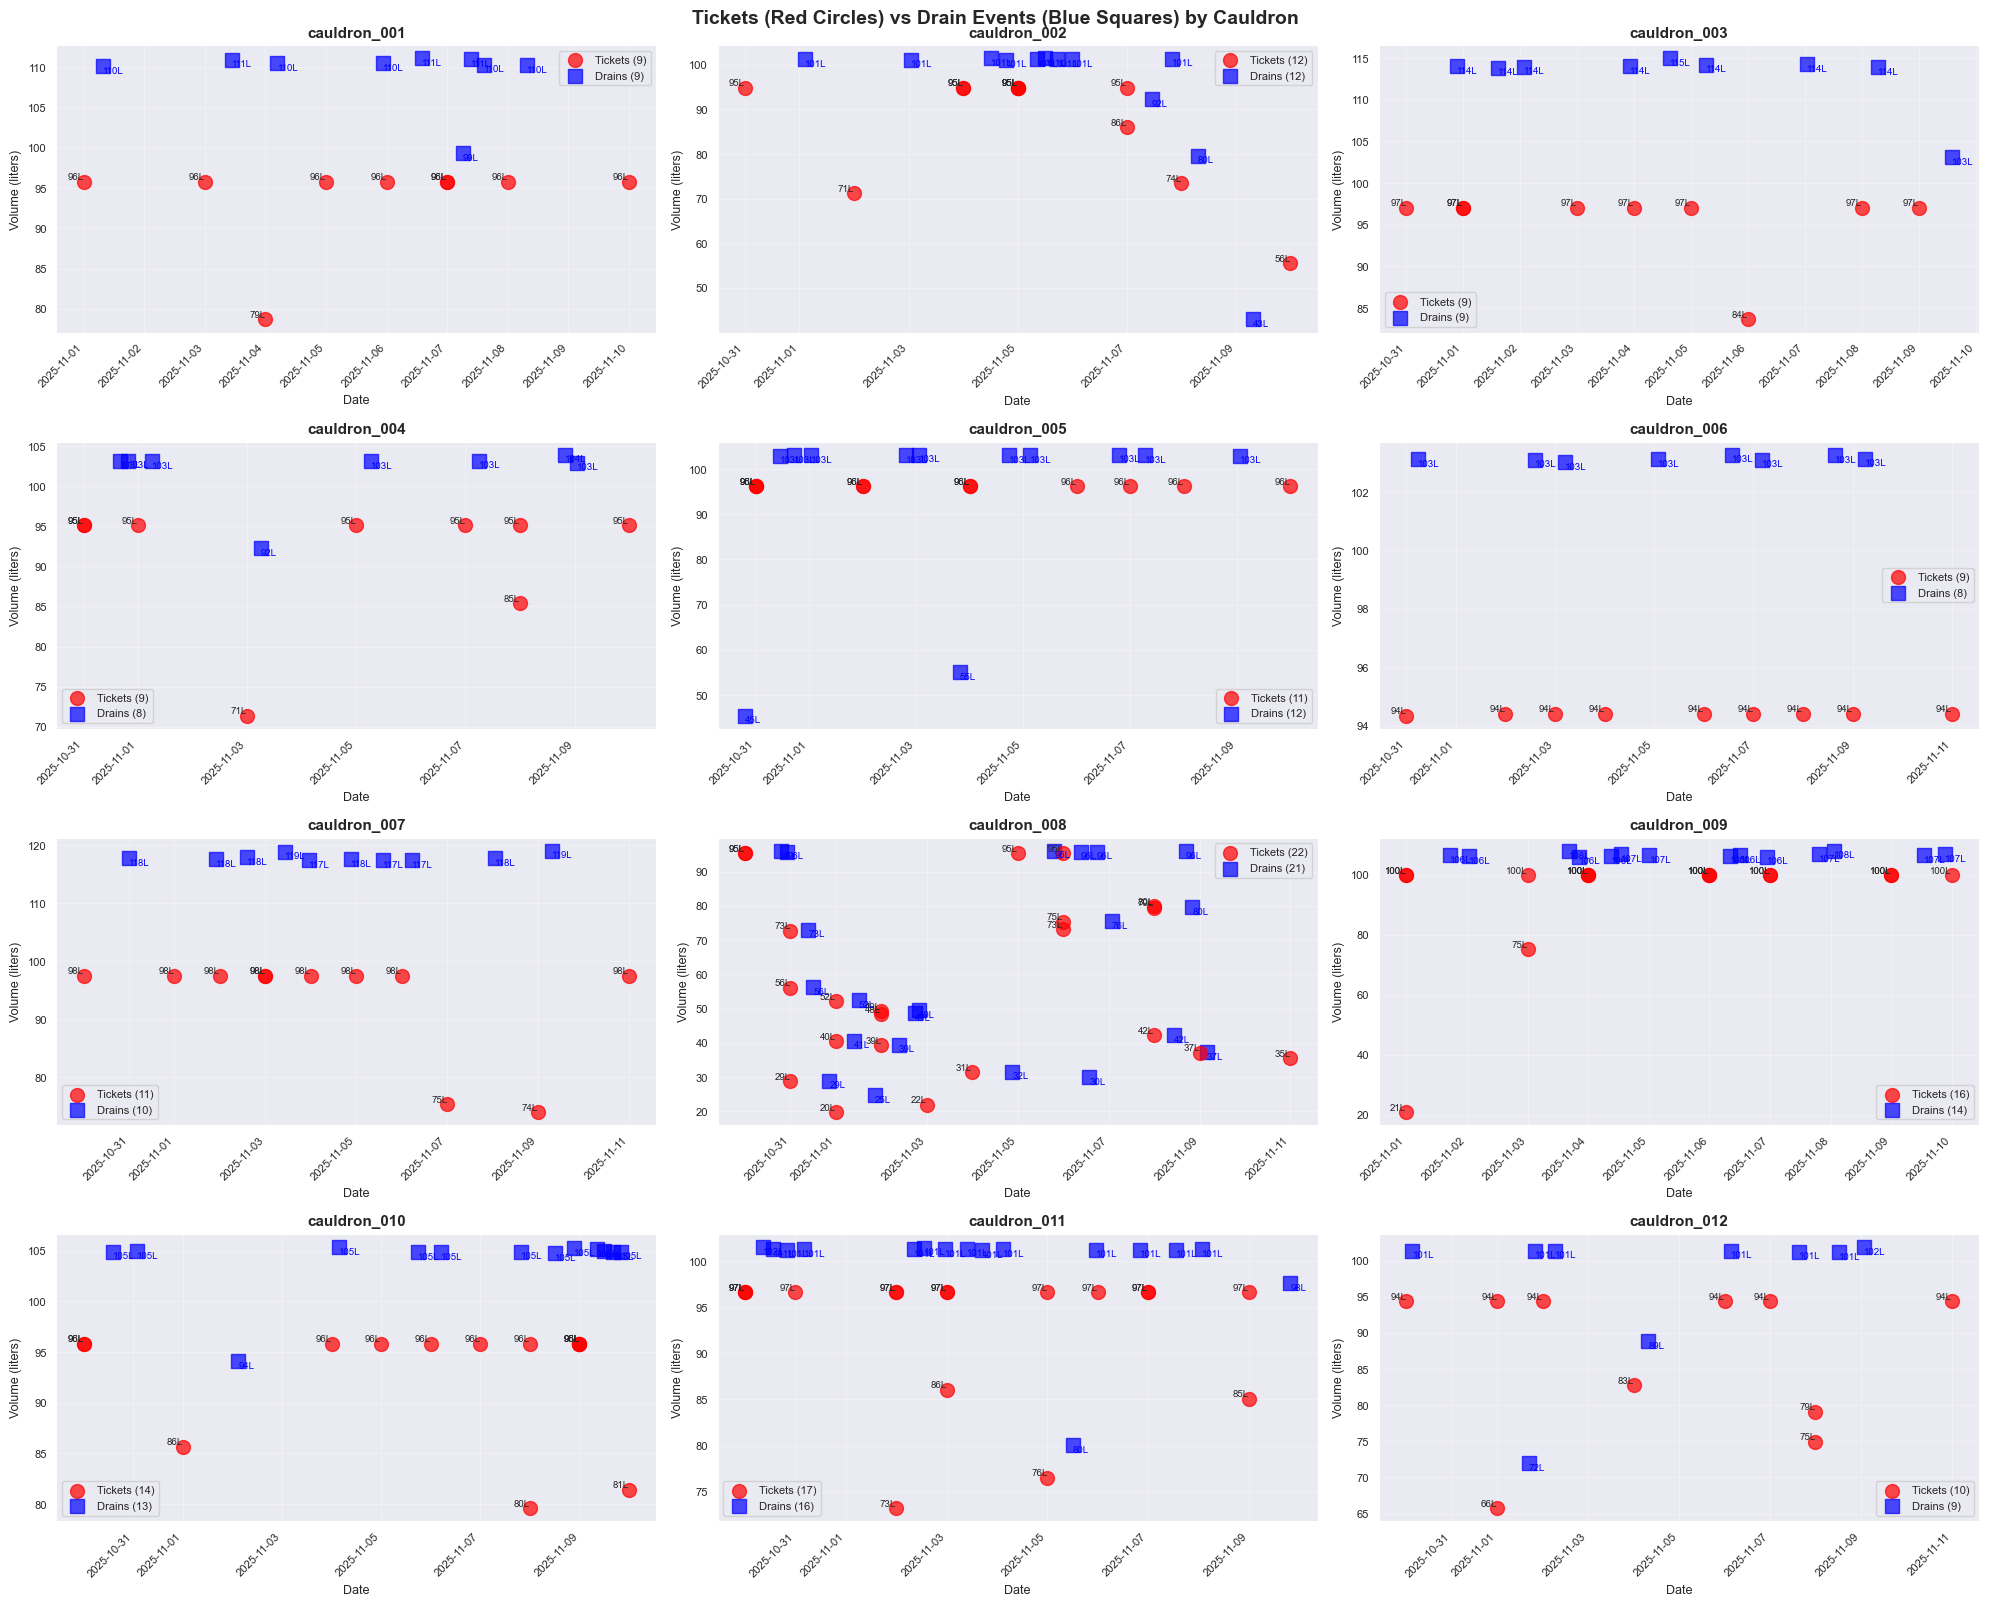


📊 Red circles = Tickets (from tickets API)
📊 Blue squares = Detected drain events (from level data)
📊 They should align closely if matching is working correctly


In [85]:
# Visualize tickets and drains timeline
if len(df_drain_events) > 0:
    # Create timeline comparison for each cauldron
    fig, axes = plt.subplots(4, 3, figsize=(20, 16))
    axes = axes.flatten()
    
    all_cauldron_ids = sorted(df_tickets['cauldron_id'].unique())
    
    for idx, cauldron_id in enumerate(all_cauldron_ids):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        
        # Get tickets for this cauldron
        cauldron_tickets = df_tickets[df_tickets['cauldron_id'] == cauldron_id].sort_values('date')
        
        # Get drain events for this cauldron
        cauldron_drains = df_drain_events[df_drain_events['cauldron_id'] == cauldron_id].sort_values('end_time')
        
        # Plot tickets as red markers
        if len(cauldron_tickets) > 0:
            ticket_dates = pd.to_datetime(cauldron_tickets['date'])
            ticket_amounts = cauldron_tickets['amount_collected']
            ax.scatter(ticket_dates, ticket_amounts, color='red', marker='o', 
                      s=100, alpha=0.7, label=f'Tickets ({len(cauldron_tickets)})', zorder=3)
            
            # Add ticket labels
            for _, ticket in cauldron_tickets.iterrows():
                ax.text(pd.to_datetime(ticket['date']), ticket['amount_collected'], 
                       f"{ticket['amount_collected']:.0f}L", 
                       fontsize=7, ha='right', va='bottom')
        
        # Plot drain events as blue markers
        if len(cauldron_drains) > 0:
            drain_dates = pd.to_datetime(cauldron_drains['end_time'])
            drain_amounts = cauldron_drains['total_collected']
            ax.scatter(drain_dates, drain_amounts, color='blue', marker='s', 
                      s=100, alpha=0.7, label=f'Drains ({len(cauldron_drains)})', zorder=2)
            
            # Add drain labels
            for _, drain in cauldron_drains.iterrows():
                ax.text(pd.to_datetime(drain['end_time']), drain['total_collected'], 
                       f"{drain['total_collected']:.0f}L", 
                       fontsize=7, ha='left', va='top', color='blue')
        
        ax.set_title(f"{cauldron_id}", fontsize=11, fontweight='bold')
        ax.set_xlabel('Date', fontsize=9)
        ax.set_ylabel('Volume (liters)', fontsize=9)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=8)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Hide unused subplots
    for idx in range(len(all_cauldron_ids), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('Tickets (Red Circles) vs Drain Events (Blue Squares) by Cauldron', 
                 fontsize=14, fontweight='bold', y=1.001)
    plt.show()
    
    print("\n📊 Red circles = Tickets (from tickets API)")
    print("📊 Blue squares = Detected drain events (from level data)")
    print("📊 They should align closely if matching is working correctly")
else:
    print("\n⚠️ No drain events to compare with tickets")


In [86]:
# Create a detailed comparison table
if len(df_drain_events) > 0:
    print("\n" + "="*80)
    print("DETAILED TICKET vs DRAIN COMPARISON BY DATE")
    print("="*80)
    
    for cauldron_id in sorted(df_tickets['cauldron_id'].unique()):
        cauldron_tickets = df_tickets[df_tickets['cauldron_id'] == cauldron_id].sort_values('date')
        cauldron_drains = df_drain_events[df_drain_events['cauldron_id'] == cauldron_id].sort_values('end_time')
        
        if len(cauldron_tickets) > 0 or len(cauldron_drains) > 0:
            print(f"\n{'─'*80}")
            print(f"🔮 {cauldron_id.upper()}")
            print(f"{'─'*80}")
            
            # Group drains by date
            if len(cauldron_drains) > 0:
                cauldron_drains_copy = cauldron_drains.copy()
                cauldron_drains_copy['date_only'] = pd.to_datetime(cauldron_drains_copy['end_time']).dt.date
                drains_by_date = cauldron_drains_copy.groupby('date_only')['total_collected'].agg(['count', 'sum'])
            else:
                drains_by_date = pd.DataFrame()
            
            # Create date range
            all_dates = set()
            if len(cauldron_tickets) > 0:
                all_dates.update(cauldron_tickets['date'].dt.date)
            if len(cauldron_drains) > 0:
                all_dates.update(pd.to_datetime(cauldron_drains['end_time']).dt.date)
            
            if len(all_dates) > 0:
                print(f"{'Date':<12} | {'Tickets':<8} | {'Ticket Vol':<11} | {'Drains':<7} | {'Drain Vol':<11} | {'Match?':<6}")
                print(f"{'-'*12}-+-{'-'*8}-+-{'-'*11}-+-{'-'*7}-+-{'-'*11}-+-{'-'*6}")
                
                for date in sorted(all_dates):
                    # Tickets on this date
                    date_tickets = cauldron_tickets[cauldron_tickets['date'].dt.date == date]
                    ticket_count = len(date_tickets)
                    ticket_vol = date_tickets['amount_collected'].sum() if ticket_count > 0 else 0
                    
                    # Drains on this date
                    if date in drains_by_date.index:
                        drain_count = int(drains_by_date.loc[date, 'count'])
                        drain_vol = drains_by_date.loc[date, 'sum']
                    else:
                        drain_count = 0
                        drain_vol = 0
                    
                    # Check if they match
                    match_status = "✓" if (ticket_count > 0 and drain_count > 0 and 
                                          abs(ticket_vol - drain_vol) < ticket_vol * 0.1) else "✗"
                    
                    if ticket_count > 0 or drain_count > 0:
                        print(f"{str(date):<12} | {ticket_count:>8} | {ticket_vol:>9.1f} L | "
                              f"{drain_count:>7} | {drain_vol:>9.1f} L | {match_status:>6}")
    
    print("\n" + "="*80)
else:
    print("\n⚠️ No drain events detected - cannot compare with tickets")



DETAILED TICKET vs DRAIN COMPARISON BY DATE

────────────────────────────────────────────────────────────────────────────────
🔮 CAULDRON_001
────────────────────────────────────────────────────────────────────────────────
Date         | Tickets  | Ticket Vol  | Drains  | Drain Vol   | Match?
-------------+----------+-------------+---------+-------------+-------
2025-11-01   |        1 |      95.8 L |       1 |     110.1 L |      ✗
2025-11-03   |        1 |      95.8 L |       1 |     110.9 L |      ✗
2025-11-04   |        1 |      78.7 L |       1 |     110.5 L |      ✗
2025-11-05   |        1 |      95.8 L |       1 |     110.5 L |      ✗
2025-11-06   |        1 |      95.8 L |       1 |     111.1 L |      ✗
2025-11-07   |        2 |     191.6 L |       3 |     320.5 L |      ✗
2025-11-08   |        1 |      95.8 L |       1 |     110.2 L |      ✗
2025-11-10   |        1 |      95.8 L |       0 |       0.0 L |      ✗

──────────────────────────────────────────────────────────────────

## 12. Advanced Analytics & Forecasting

Calculate overflow risk, capacity utilization, and system-wide metrics.


In [88]:
# Calculate overflow forecasting for each cauldron
print("="*70)
print("OVERFLOW RISK ANALYSIS")
print("="*70)

overflow_analysis = []

for _, cauldron in df_cauldrons.iterrows():
    cauldron_id = cauldron.name if isinstance(cauldron.name, str) else cauldron.get('id', '')
    max_volume = cauldron.get('max_volume', np.nan)
    
    # Get current level (last recorded)
    cauldron_col = f'cauldron_levels.{cauldron_id}'
    if cauldron_col in df_levels.columns:
        current_level = df_levels[cauldron_col].iloc[-1]
        
        # Get fill rate
        fill_rate_data = df_fill_rates[df_fill_rates['cauldron'] == cauldron_col]
        if len(fill_rate_data) > 0:
            fill_rate_per_min = fill_rate_data['fill_rate_per_min'].values[0]
            
            if not np.isnan(max_volume) and not np.isnan(fill_rate_per_min) and fill_rate_per_min > 0:
                # Calculate time to overflow
                remaining_capacity = max_volume - current_level
                hours_to_overflow = (remaining_capacity / fill_rate_per_min) / 60
                
                # Capacity utilization
                utilization_pct = (current_level / max_volume) * 100
                
                overflow_analysis.append({
                    'cauldron_id': cauldron_id,
                    'current_level': current_level,
                    'max_volume': max_volume,
                    'remaining_capacity': remaining_capacity,
                    'utilization_pct': utilization_pct,
                    'fill_rate_per_hour': fill_rate_per_min * 60,
                    'hours_to_overflow': hours_to_overflow,
                    'risk_level': 'HIGH' if hours_to_overflow < 12 else ('MEDIUM' if hours_to_overflow < 24 else 'LOW')
                })

df_overflow = pd.DataFrame(overflow_analysis)

if len(df_overflow) > 0:
    print(f"\n{'Cauldron':<15} {'Current':<10} {'Capacity':<10} {'Utilization':<12} {'Hours to':<12} {'Risk':<8}")
    print(f"{'ID':<15} {'Level (L)':<10} {'(L)':<10} {'(%)':<12} {'Overflow':<12} {'Level':<8}")
    print("-"*70)
    
    for _, row in df_overflow.sort_values('hours_to_overflow').iterrows():
        print(f"{row['cauldron_id']:<15} {row['current_level']:>9.1f} {row['max_volume']:>9.0f} "
              f"{row['utilization_pct']:>10.1f}% {row['hours_to_overflow']:>10.1f}h  {row['risk_level']:<8}")
    
    print("\n" + "="*70)
    print(f"⚠️  {len(df_overflow[df_overflow['risk_level'] == 'HIGH'])} cauldrons at HIGH risk (< 12 hours to overflow)")
    print(f"⚠️  {len(df_overflow[df_overflow['risk_level'] == 'MEDIUM'])} cauldrons at MEDIUM risk (12-24 hours)")
    print(f"✓  {len(df_overflow[df_overflow['risk_level'] == 'LOW'])} cauldrons at LOW risk (> 24 hours)")
else:
    print("\n⚠️ Unable to calculate overflow risk")


OVERFLOW RISK ANALYSIS

Cauldron        Current    Capacity   Utilization  Hours to     Risk    
ID              Level (L)  (L)        (%)          Overflow     Level   
----------------------------------------------------------------------
cauldron_009        906.3       950       95.4%        3.3h  HIGH    
cauldron_007        877.1      1100       79.7%       18.6h  MEDIUM  
cauldron_004        538.8       750       71.8%       32.0h  LOW     
cauldron_012        382.0       600       63.7%       36.3h  LOW     
cauldron_001        640.4      1000       64.0%       37.5h  LOW     
cauldron_003        757.5      1200       63.1%       41.0h  LOW     
cauldron_006        266.4       650       41.0%       63.9h  LOW     
cauldron_005        419.2       900       46.6%       72.8h  LOW     
cauldron_002        204.2       800       25.5%       99.3h  LOW     
cauldron_010        132.8       850       15.6%       99.6h  LOW     
cauldron_008        144.5       700       20.6%      115.7h

In [89]:
# System-wide discrepancy analysis
print("\n" + "="*70)
print("SYSTEM-WIDE DISCREPANCY SUMMARY")
print("="*70)

if len(df_matched) > 0:
    # Total volumes
    total_drained = df_matched['drain_amount'].sum()
    total_ticketed = df_matched[df_matched['ticket_amount'].notna()]['ticket_amount'].sum()
    total_unaccounted = total_drained - total_ticketed
    
    # Breakdown by status
    matched = df_matched[df_matched['status'] == 'MATCHED']
    under_reported = df_matched[df_matched['status'] == 'UNDER_REPORTED']
    over_reported = df_matched[df_matched['status'] == 'OVER_REPORTED']
    no_ticket = df_matched[df_matched['status'] == 'NO_TICKET_FOUND']
    
    print(f"\n📊 VOLUME SUMMARY:")
    print(f"  Total potion drained (detected):  {total_drained:>10.2f} L")
    print(f"  Total potion ticketed (reported):  {total_ticketed:>10.2f} L")
    print(f"  Total unaccounted:                 {total_unaccounted:>10.2f} L ({(total_unaccounted/total_drained)*100:.1f}%)")
    
    print(f"\n🎫 MATCHING BREAKDOWN:")
    print(f"  Matched drains:       {len(matched):>4} events | {matched['drain_amount'].sum():>8.2f} L")
    print(f"  Under-reported:       {len(under_reported):>4} events | {abs(under_reported['difference'].sum()):>8.2f} L missing")
    if len(over_reported) > 0:
        print(f"  Over-reported:        {len(over_reported):>4} events | {over_reported['difference'].sum():>8.2f} L excess")
    print(f"  No ticket found:      {len(no_ticket):>4} events | {no_ticket['drain_amount'].sum():>8.2f} L unlogged")
    
    # Accuracy metric
    accuracy = (len(matched) / len(df_matched)) * 100
    print(f"\n✓ Ticketing accuracy: {accuracy:.1f}% of drains properly reported")
    
    # Top suspicious cauldrons
    if len(under_reported) > 0:
        print(f"\n⚠️  TOP UNDER-REPORTING CAULDRONS:")
        under_by_cauldron = under_reported.groupby('cauldron_id').agg({
            'difference': lambda x: abs(x.sum()),
            'drain_amount': 'count'
        }).sort_values('difference', ascending=False).head(5)
        
        for cauldron_id, row in under_by_cauldron.iterrows():
            print(f"  {cauldron_id}: {row['difference']:.2f} L missing across {row['drain_amount']} events")

print("\n" + "="*70)



SYSTEM-WIDE DISCREPANCY SUMMARY

📊 VOLUME SUMMARY:
  Total potion drained (detected):    13674.37 L
  Total potion ticketed (reported):    10310.29 L
  Total unaccounted:                    3364.08 L (24.6%)

🎫 MATCHING BREAKDOWN:
  Matched drains:         18 events |  1156.33 L
  Under-reported:         96 events |   975.20 L missing
  Over-reported:           2 events |    45.82 L excess
  No ticket found:        25 events |  2428.77 L unlogged

✓ Ticketing accuracy: 12.8% of drains properly reported

⚠️  TOP UNDER-REPORTING CAULDRONS:
  cauldron_007: 186.75 L missing across 8.0 events
  cauldron_001: 138.75 L missing across 9.0 events
  cauldron_003: 108.86 L missing across 7.0 events
  cauldron_010: 100.47 L missing across 11.0 events
  cauldron_009: 73.85 L missing across 11.0 events



## 13. Executive Summary

Final report with all key findings and recommendations.


In [90]:
print("\n" + "="*80)
print(" "*25 + "🧙 POTION FACTORY MONITORING REPORT")
print("="*80)

print(f"\n📅 MONITORING PERIOD:")
print(f"  Start: {df_levels.index.min()}")
print(f"  End:   {df_levels.index.max()}")
print(f"  Duration: {(df_levels.index.max() - df_levels.index.min()).days} days")

print(f"\n🏭 FACILITY OVERVIEW:")
print(f"  Active cauldrons: {len(cauldron_cols)}")
print(f"  Data points collected: {len(df_levels):,}")
print(f"  Average fill rate: {df_fill_rates['fill_rate_per_hour'].mean():.2f} L/hour")

if len(df_drain_events) > 0:
    print(f"\n💧 COLLECTION ACTIVITY:")
    print(f"  Total drain events detected: {len(df_drain_events)}")
    print(f"  Total potion collected: {df_drain_events['total_collected'].sum():.2f} L")
    print(f"  Average per collection: {df_drain_events['total_collected'].mean():.2f} L")
    print(f"  Collections per cauldron: {len(df_drain_events)/len(cauldron_cols):.1f}")

if len(df_matched) > 0:
    matched_pct = (len(df_matched[df_matched['status'] == 'MATCHED']) / len(df_matched)) * 100
    print(f"\n🎫 TICKET VERIFICATION:")
    print(f"  Total transport tickets: {len(df_tickets)}")
    print(f"  Matching accuracy: {matched_pct:.1f}%")
    print(f"  Suspicious discrepancies: {len(df_matched[df_matched['status'].isin(['UNDER_REPORTED', 'NO_TICKET_FOUND'])])}")
    
    total_missing = abs(df_matched[df_matched['difference'] < 0]['difference'].sum())
    if total_missing > 0:
        print(f"  ⚠️  CRITICAL: {total_missing:.2f} L of potion unaccounted for")

if len(df_overflow) > 0:
    high_risk = df_overflow[df_overflow['risk_level'] == 'HIGH']
    print(f"\n⚡ OVERFLOW RISK STATUS:")
    if len(high_risk) > 0:
        print(f"  ⚠️  HIGH PRIORITY: {len(high_risk)} cauldrons need immediate attention")
        print(f"  Cauldrons at risk: {', '.join(high_risk['cauldron_id'].values)}")
    else:
        print(f"  ✓  No immediate overflow risk detected")
    print(f"  Average capacity utilization: {df_overflow['utilization_pct'].mean():.1f}%")

print(f"\n🎯 RECOMMENDATIONS:")
if len(df_matched) > 0:
    under_reported = df_matched[df_matched['status'] == 'UNDER_REPORTED']
    no_ticket = df_matched[df_matched['status'] == 'NO_TICKET_FOUND']
    
    if len(under_reported) > 0:
        print(f"  • Investigate {len(under_reported)} under-reported collections")
    if len(no_ticket) > 0:
        print(f"  • Track down {len(no_ticket)} unlogged drain events")

if len(df_overflow) > 0:
    high_risk = df_overflow[df_overflow['risk_level'] == 'HIGH']
    if len(high_risk) > 0:
        print(f"  • Schedule immediate collections for high-risk cauldrons")
    
    avg_hours = df_overflow['hours_to_overflow'].mean()
    if avg_hours < 24:
        print(f"  • Increase courier frequency (avg {avg_hours:.1f}h to overflow)")

print(f"  • Continue monitoring for anomalies")
print(f"  • Verify travel time adjustments for accurate ticket matching")

print("\n" + "="*80)
print(" "*30 + "End of Report")
print("="*80)



                         🧙 POTION FACTORY MONITORING REPORT

📅 MONITORING PERIOD:
  Start: 2025-10-30 00:00:00+00:00
  End:   2025-11-09 23:59:00+00:00
  Duration: 10 days

🏭 FACILITY OVERVIEW:
  Active cauldrons: 12
  Data points collected: 15,840
  Average fill rate: 7.95 L/hour

💧 COLLECTION ACTIVITY:
  Total drain events detected: 141
  Total potion collected: 13674.37 L
  Average per collection: 96.98 L
  Collections per cauldron: 11.8

🎫 TICKET VERIFICATION:
  Total transport tickets: 149
  Matching accuracy: 12.8%
  Suspicious discrepancies: 121
  ⚠️  CRITICAL: 981.13 L of potion unaccounted for

⚡ OVERFLOW RISK STATUS:
  ⚠️  HIGH PRIORITY: 1 cauldrons need immediate attention
  Cauldrons at risk: cauldron_009
  Average capacity utilization: 50.9%

🎯 RECOMMENDATIONS:
  • Investigate 96 under-reported collections
  • Track down 25 unlogged drain events
  • Schedule immediate collections for high-risk cauldrons
  • Continue monitoring for anomalies
  • Verify travel time adjustme

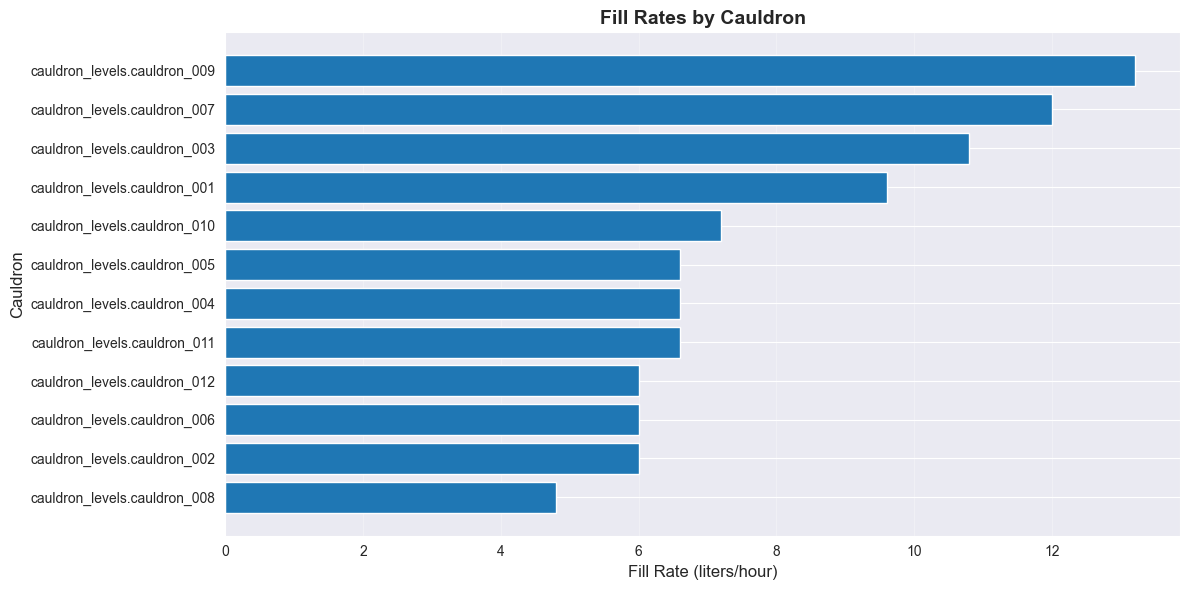

In [69]:
# Plot fill rates comparison
plt.figure(figsize=(12, 6))
df_fill_rates_sorted = df_fill_rates.sort_values('fill_rate_per_hour')
plt.barh(df_fill_rates_sorted['cauldron'], df_fill_rates_sorted['fill_rate_per_hour'])
plt.xlabel('Fill Rate (liters/hour)', fontsize=12)
plt.ylabel('Cauldron', fontsize=12)
plt.title('Fill Rates by Cauldron', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


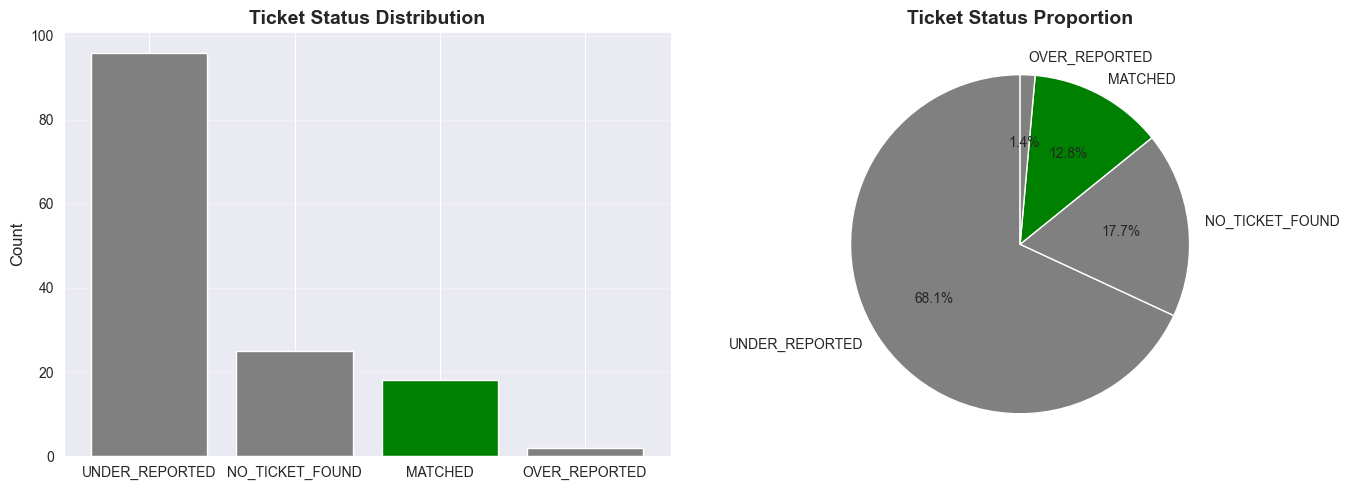

In [91]:
# Plot ticket status distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Status counts
status_counts = df_matched['status'].value_counts()
colors = {'MATCHED': 'green', 'SUSPICIOUS': 'orange', 'NO_DRAIN_FOUND': 'red'}
status_colors = [colors.get(status, 'gray') for status in status_counts.index]

ax1.bar(status_counts.index, status_counts.values, color=status_colors)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Ticket Status Distribution', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Pie chart
ax2.pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%',
        colors=status_colors, startangle=90)
ax2.set_title('Ticket Status Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


## 10. Export Results


In [ ]:
# Export analysis results to CSV files
print("💾 Exporting analysis results...\n")

df_drain_events.to_csv('drain_events.csv', index=False)
df_matched.to_csv('ticket_matching.csv', index=False)
df_fill_rates.to_csv('fill_rates.csv', index=False)

print("✓ Exported 3 files: drain_events.csv, ticket_matching.csv, fill_rates.csv")
